In [1]:
from google.colab import files
uploads = files.upload()

Saving vgames2.csv to vgames2.csv


In [390]:
import pandas as pd
import numpy as np

# vgames 데이터셋 결측치 및 필요없는 값, 열 제거
df = pd.read_csv('vgames2.csv')
df = df.dropna()
df = df.sort_values(by=['Year'], axis=0)
df = df.reset_index().drop(columns=['index', 'Unnamed: 0'])
drop_error = df[(df['Year'] >= 1900) & (df['Platform'] != '2600')]
df_sorted = drop_error.reset_index().drop(columns=['index'])

# Sales 열에 K, M 문자 제거 (K, M을 각각 1e3, 1e6으로 변환하면 범위가 너무 커져서 다루기 힘듬)
def remove_km(df, col):
  for i in df.index:# 행으로 접근
    val = df.loc[i, col] # loc(행 인덱스 번호, 열 이름)
    if 'K' in val:
      splited_k = df.loc[i, col].split('K')
      splited_k = float(splited_k[0])
      df.loc[i, col] = str(splited_k)
      continue
    if 'M' in val:
      splited_M = df.loc[i, col].split('M')
      splited_M = float(splited_M[0])
      df.loc[i, col] = str(splited_M)

# 정의한 함수 데이터프레임에 적용
remove_km(df_sorted, 'NA_Sales')
remove_km(df_sorted, 'EU_Sales')
remove_km(df_sorted, 'JP_Sales')
remove_km(df_sorted, 'Other_Sales')

# Sales 열 실수로 변환
for i in df_sorted:
  if i == 'Name' or i == 'Platform' or i == 'Year' or i == 'Genre' or i == 'Publisher':
    continue
  df_sorted[i] = round(df_sorted[i].apply(float), 2)

df_ps = df_sorted.copy()
df_platform = df_sorted.copy()
df_best = df_sorted.copy()

# 4개의 열의 데이터가 모두 같으면 Sales 값을 다 합침 Groupby.agg() 함수 사용
df_sorted = df_sorted.groupby(['Name', 'Year', 'Genre', 'Publisher']).agg({'Platform':', '.join, 'NA_Sales':sum, 'EU_Sales':sum, 'JP_Sales':sum, 'Other_Sales':sum}).reset_index()
df_sorted

,Name,Year,Genre,Publisher,Platform,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,'98 Koshien,1998.0,Sports,Magical Company,PS,0.15,0.10,0.12,0.03
1,.hack//G.U. Vol.1//Rebirth,2006.0,Role-Playing,Namco Bandai Games,PS2,0.00,0.00,0.17,0.00
2,.hack//G.U. Vol.2//Reminisce,2006.0,Role-Playing,Namco Bandai Games,PS2,0.11,0.09,0.00,0.03
3,.hack//G.U. Vol.2//Reminisce (jp sales),2006.0,Role-Playing,Namco Bandai Games,PS2,0.00,0.00,0.16,0.00
4,.hack//G.U. Vol.3//Redemption,2007.0,Role-Playing,Namco Bandai Games,PS2,0.00,0.00,0.17,0.00
...,...,...,...,...,...,...,...,...,...
12026,thinkSMART FAMILY!,2010.0,Misc,Conspiracy Entertainment,Wii,0.03,0.00,0.00,0.00
12027,thinkSMART: Chess for Kids,2011.0,Misc,Mentor Interactive,DS,0.01,0.00,0.00,0.00
12028,uDraw Studio,2010.0,Misc,THQ,Wii,1.67,0.58,0.00,0.20
12029,uDraw Studio: Instant Artist,2011.0,Misc,THQ,"X360, Wii",0.09,0.10,0.00,0.02


In [250]:
# 지역에 따라서 선호하는 게임 장르가 다를까

# 1. 장르(Genre)를 기준으로 묶고, Sales 열은 중복된 장르는 해당 Sales 값을 다 합함. 
df_genre = df_sorted.copy()
df_genre = df_genre.groupby(['Genre']).agg({'Name':'first', 'Year': 'first', 'Publisher':','.join, 'Platform': ','.join, 'NA_Sales': sum, 'EU_Sales':sum, 'JP_Sales':sum, 'Other_Sales':sum}).reset_index()

# 2. Sales 열을 제외한 나머지 열은 위의 주제에 필요없으므로, 결측치로 대체한다.
def remove_name(df, col):
  for i in df.index:
    val = df.loc[i, col]
    val = '-'
    df.loc[i, col] = val

# 2.1 위의 함수(결측치 대체 함수)를 필요없는 열에 적용
remove_name(df_genre, 'Name')
remove_name(df_genre, 'Year')
remove_name(df_genre, 'Publisher')
remove_name(df_genre, 'Platform')

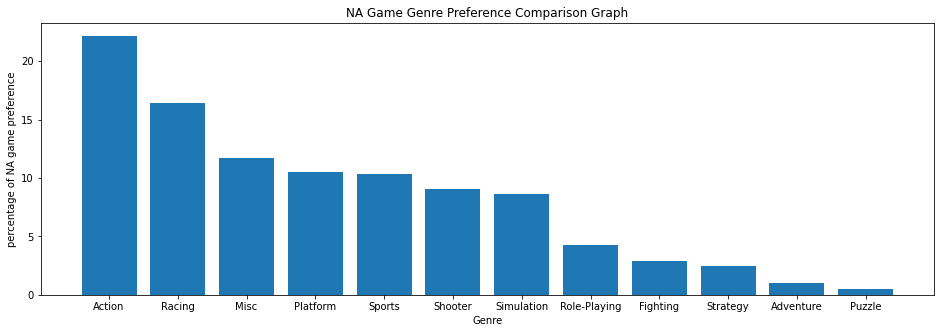

In [251]:
# 북미(NA)지역에서 선호하는 게임을 분석 및 시각화
import matplotlib.pyplot as plt

df_NA = df_genre.copy()
df_NA = df_NA.sort_values(by=['NA_Sales'], axis=0, ascending=False).reset_index().drop(columns=['index']) # 내림차순 정렬 및 인덱스 초기화

# 지역에서 선호하는 게임의 장르를 비율로 변환
def calculate_percentage(df, col):
  val_sum = 0
  for i in df.index:
    val = df.loc[i, col]
    val_sum += val
  
  for j in df.index:
    # ds = df.copy()
    data = df.loc[j, col]
    data = (data/val_sum) * 100
    df.loc[j, col] = round(data, 2)
  return df

# 함수 적용
df_NA_percentage = calculate_percentage(df_NA, 'NA_Sales')

# 막대 그래프로 시각화
plt.rcParams["figure.figsize"] = (16,5) # 그래프 창 크기 조절
x_na = np.array(df_NA_percentage['Genre'])
y_na = np.array(df_NA_percentage['NA_Sales'])
plt.bar(x_na, y_na)
plt.title('NA Game Genre Preference Comparison Graph')
plt.xlabel('Genre')
plt.ylabel('percentage of NA game preference')
plt.show();

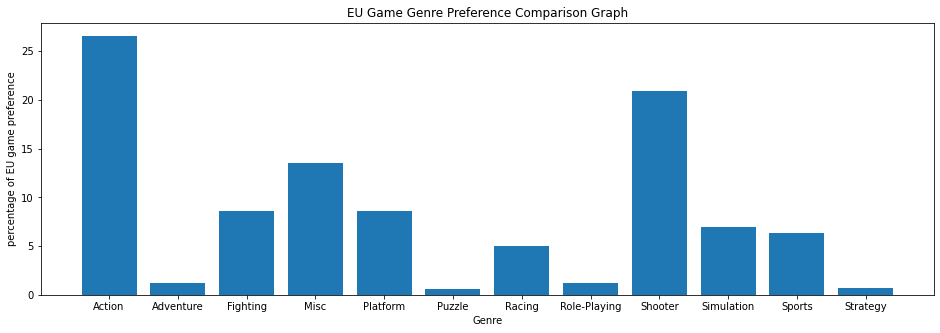

In [252]:
# 유럽(EU)지역에서 선호하는 게임을 분석 및 시각화

df_EU = df_genre.copy()
df_EU_percentage = calculate_percentage(df_EU, 'EU_Sales')
df_EU_percentage

# 시각화
plt.rcParams["figure.figsize"] = (16,5)
x_eu = np.array(df_EU_percentage['Genre'])
y_eu = np.array(df_EU_percentage['EU_Sales'])
plt.bar(x_eu, y_eu)
plt.title('EU Game Genre Preference Comparison Graph')
plt.xlabel('Genre')
plt.ylabel('percentage of EU game preference')
plt.show();

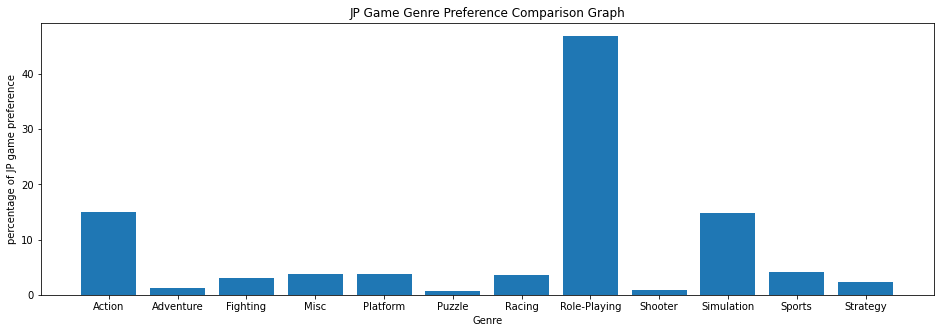

In [253]:
# 일본(JP)지역에서 선호하는 게임을 분석 및 시각화

df_JP = df_genre.copy()
df_JP_percentage = calculate_percentage(df_JP, 'JP_Sales')

# 시각화
x_jp = np.array(df_JP_percentage['Genre'])
y_jp = np.array(df_JP_percentage['JP_Sales'])
plt.rcParams["figure.figsize"] = (16,5)
plt.bar(x_jp, y_jp)
plt.title('JP Game Genre Preference Comparison Graph')
plt.xlabel('Genre')
plt.ylabel('percentage of JP game preference')
plt.show();

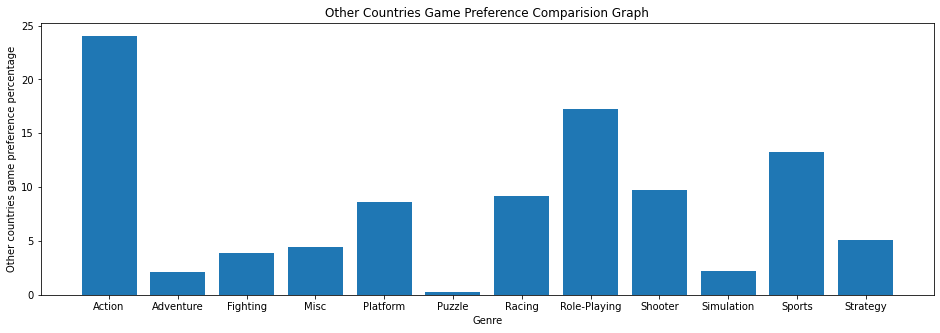

In [254]:
# 그 외(Others)지역에서 선호하는 게임을 분석 및 시각화

df_others = df_genre.copy()
df_others_percentage = calculate_percentage(df_others, 'Other_Sales')

# 시각화
x_other = np.array(df_others_percentage['Genre'])
y_other = np.array(df_others_percentage['Other_Sales'])
plt.rcParams["figure.figsize"] = (16,5)
plt.bar(x_other, y_other)
plt.title('Other Countries Game Preference Comparision Graph')
plt.xlabel('Genre')
plt.ylabel('Other countries game preference percentage')
plt.show();

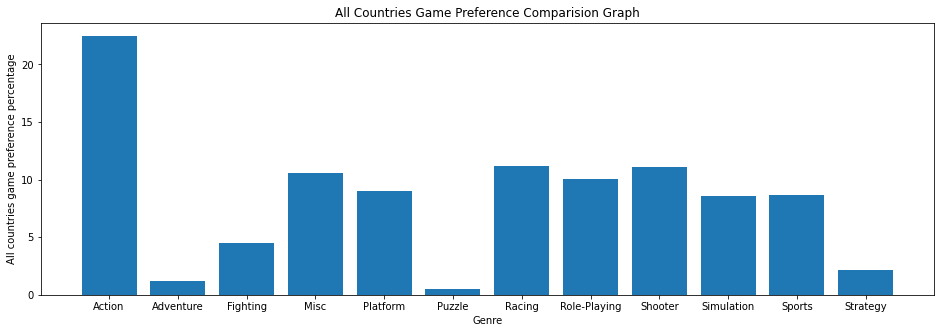

In [255]:
# 종합 지역에서 선호하는 게임을 분석 및 시각화
df_total_sale = df_genre.copy()

# 반복문을 이용하여 Sales 열의 데이터 값의 총합인 열 Total_Sales 열 생성
def create_total(df):
  df['Total_Sales'] = 0
  for i in range(len(df)):
    for j in range(5, 9):
      df.iloc[i, 9] += df.iloc[i, j]
  return df

df_total_sale = create_total(df_total_sale)

df_total_percentage = calculate_percentage(df_total_sale, 'Total_Sales')

# 시각화
x_total = np.array(df_total_sale['Genre'])
y_total = np.array(df_total_sale['Total_Sales'])
plt.rcParams["figure.figsize"] = (16,5)
plt.bar(x_total, y_total)
plt.title('All Countries Game Preference Comparision Graph')
plt.xlabel('Genre')
plt.ylabel('All countries game preference percentage')
plt.show();

In [256]:
# 연도별 게임의 트렌드가 있을까 - 장르 기준

df_trand = df_sorted.copy()
remove_name(df_trand, 'Name')
remove_name(df_trand, 'Publisher')
remove_name(df_trand, 'Platform')

In [257]:
# 반복문을 이용하여 Sales 열의 데이터 값의 총합인 열 Total_Sales 열 생성
df_trand = create_total(df_trand)
df_trand = df_trand.drop(columns=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'])

In [258]:
df_trand.sort_values(by=['Year'], axis=0, inplace=True)
df_trand = df_trand[['Year', 'Genre', 'Total_Sales']].sort_values(by=['Year'], axis=0).reset_index().drop(columns=['index'])

def create_yrcat(df, col):
  for i in df.index:
    val = df.loc[i, col]
    if val > 1980 and val < 1990:
      val = str(val)
      val = '1980 ~ 1989'
      df.loc[i, col] = val
    elif val >= 1990 and val < 2000:
      val = str(val)
      val = '1990 ~ 1999'
      df.loc[i, col] = val
    elif val >= 2000 and val < 2010:
      val = str(val)
      val = '2000 ~ 2009'
      df.loc[i, col] = val
    else:
      val = str(val)
      val = '2010 ~ 2020'
      df.loc[i, col] = val
  return df

df_trand = create_yrcat(df_trand, 'Year')
df_trand

,Year,Genre,Total_Sales
0,1980 ~ 1989,Platform,1.13
1,1980 ~ 1989,Platform,2.28
2,1980 ~ 1989,Platform,1.10
3,1980 ~ 1989,Misc,2.14
4,1980 ~ 1989,Sports,3.20
...,...,...,...
12026,2010 ~ 2020,Role-Playing,0.50
12027,2010 ~ 2020,Adventure,0.12
12028,2010 ~ 2020,Action,0.01
12029,2010 ~ 2020,Role-Playing,0.04


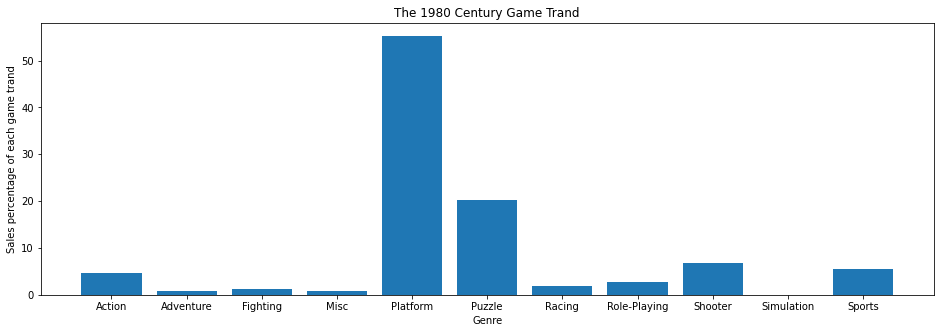

In [259]:
# 1980 ~ 1989년도의 게임 장르 트렌드 분석

df_1980st = df_trand[df_trand['Year'] == '1980 ~ 1989'].reset_index().drop(columns=['index'])
df_1980st = calculate_percentage(df_1980st[['Genre', 'Total_Sales']].groupby(['Genre']).agg({'Total_Sales':sum}), 'Total_Sales')

# 시각화
x_1980 = np.array(df_1980st.index)
y_1980 = np.array(df_1980st['Total_Sales'])
plt.rcParams["figure.figsize"] = (16,5)
plt.bar(x_1980, y_1980)
plt.xlabel('Genre')
plt.ylabel('Sales percentage of each game trand')
plt.title('The 1980 Century Game Trand')
plt.show();

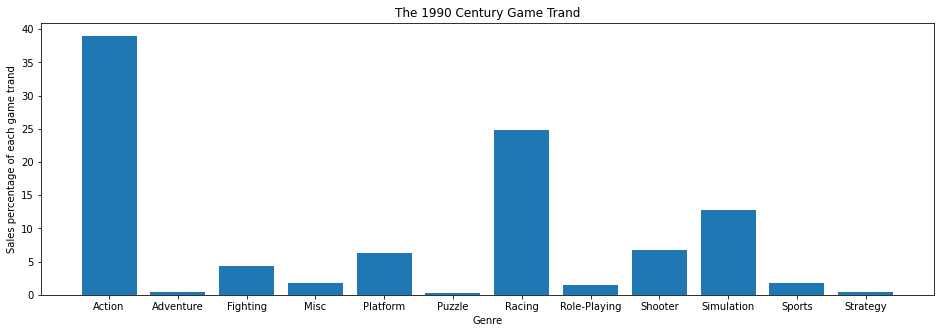

In [260]:
# 1990 ~ 1999년도의 게임 장르 트렌드 분석

df_1990st = df_trand[df_trand['Year'] == '1990 ~ 1999'].reset_index().drop(columns=['index'])
df_1990st = calculate_percentage(df_1990st[['Genre', 'Total_Sales']].groupby(['Genre']).agg({'Total_Sales':sum}), 'Total_Sales')

# 시각화
x_1990 = np.array(df_1990st.index)
y_1990 = np.array(df_1990st['Total_Sales'])
plt.rcParams["figure.figsize"] = (16,5)
plt.bar(x_1990, y_1990)
plt.xlabel('Genre')
plt.ylabel('Sales percentage of each game trand')
plt.title('The 1990 Century Game Trand')
plt.show();

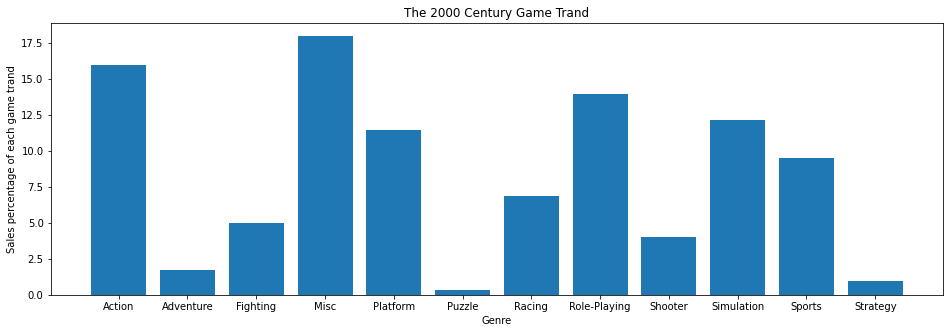

In [261]:
# 2000 ~ 2009년도의 게임 장르 트렌드 분석

df_2000st = df_trand[df_trand['Year'] == '2000 ~ 2009'].reset_index().drop(columns=['index'])
df_2000st = calculate_percentage(df_2000st[['Genre', 'Total_Sales']].groupby(['Genre']).agg({'Total_Sales':sum}), 'Total_Sales')

# 시각화
x_2000 = np.array(df_2000st.index)
y_2000 = np.array(df_2000st['Total_Sales'])
plt.rcParams["figure.figsize"] = (16,5)
plt.bar(x_2000, y_2000)
plt.xlabel('Genre')
plt.ylabel('Sales percentage of each game trand')
plt.title('The 2000 Century Game Trand')
plt.show();

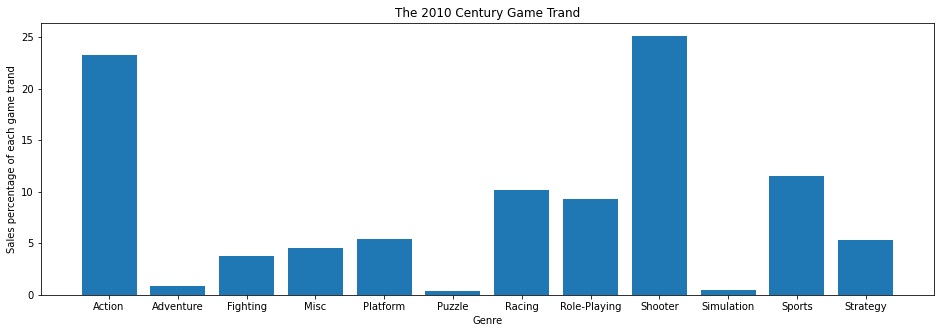

In [262]:
# 2010 ~ 2020년도의 게임 장르 트렌드 분석

df_2010st = df_trand[df_trand['Year'] == '2010 ~ 2020'].reset_index().drop(columns=['index'])
df_2010st = calculate_percentage(df_2010st[['Genre', 'Total_Sales']].groupby(['Genre']).agg({'Total_Sales':sum}), 'Total_Sales')

# 시각화
x_2010 = np.array(df_2010st.index)
y_2010 = np.array(df_2010st['Total_Sales'])
plt.rcParams["figure.figsize"] = (16,5)
plt.bar(x_2010, y_2010)
plt.xlabel('Genre')
plt.ylabel('Sales percentage of each game trand')
plt.title('The 2010 Century Game Trand')
plt.show();

In [263]:
# 연도별 게임의 트렌드가 있을까 - 사용기기 기준 - 다수 사용수준
df_platform = create_total(df_platform)

In [264]:
df_platform = df_platform[['Platform', 'Year', 'Total_Sales']].sort_values(by=['Year'], axis=0).reset_index().drop(columns=['index'])
df_platform = create_yrcat(df_platform, 'Year')
df_platform

,Platform,Year,Total_Sales
0,NES,1980 ~ 1989,3.20
1,NES,1980 ~ 1989,1.11
2,NES,1980 ~ 1989,2.14
3,NES,1980 ~ 1989,1.10
4,NES,1980 ~ 1989,1.13
...,...,...,...
16021,PS4,2010 ~ 2020,0.02
16022,PSV,2010 ~ 2020,0.01
16023,PS4,2010 ~ 2020,0.03
16024,PSV,2010 ~ 2020,0.01


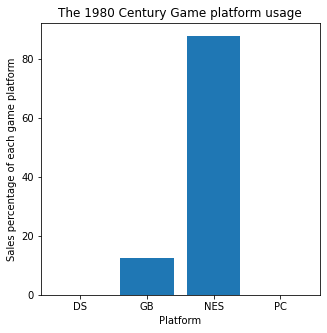

In [265]:
# 1980년도 게임 플랫폼 사용량

pt_1980st = df_platform[df_platform['Year'] == '1980 ~ 1989'].reset_index().drop(columns=['index'])
pt_1980st = calculate_percentage(pt_1980st[['Platform', 'Total_Sales']].groupby(['Platform']).agg({'Total_Sales':sum}), 'Total_Sales')

# 시각화
x_1980pt = np.array(pt_1980st.index)
y_1980pt = np.array(pt_1980st['Total_Sales'])
plt.rcParams["figure.figsize"] = (5,5)
plt.bar(x_1980pt, y_1980pt)
plt.xlabel('Platform')
plt.ylabel('Sales percentage of each game platform')
plt.title('The 1980 Century Game platform usage')
plt.show();

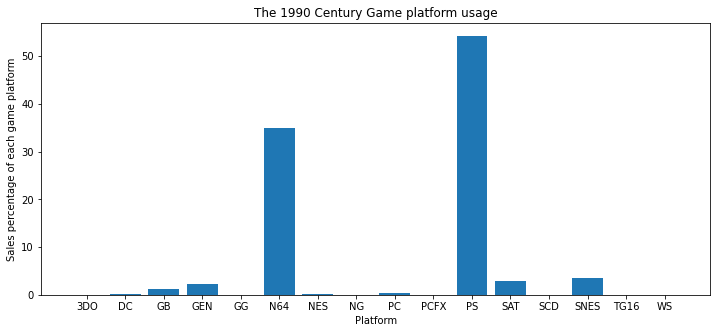

In [266]:
# 1990년도 게임 플랫폼 사용량

pt_1990st = df_platform[df_platform['Year'] == '1990 ~ 1999'].reset_index().drop(columns=['index'])
pt_1990st = calculate_percentage(pt_1990st[['Platform', 'Total_Sales']].groupby(['Platform']).agg({'Total_Sales':sum}), 'Total_Sales')

# 시각화
x_1990pt = np.array(pt_1990st.index)
y_1990pt = np.array(pt_1990st['Total_Sales'])
plt.rcParams["figure.figsize"] = (12,5)
plt.bar(x_1990pt, y_1990pt)
plt.xlabel('Platform')
plt.ylabel('Sales percentage of each game platform')
plt.title('The 1990 Century Game platform usage')
plt.show();

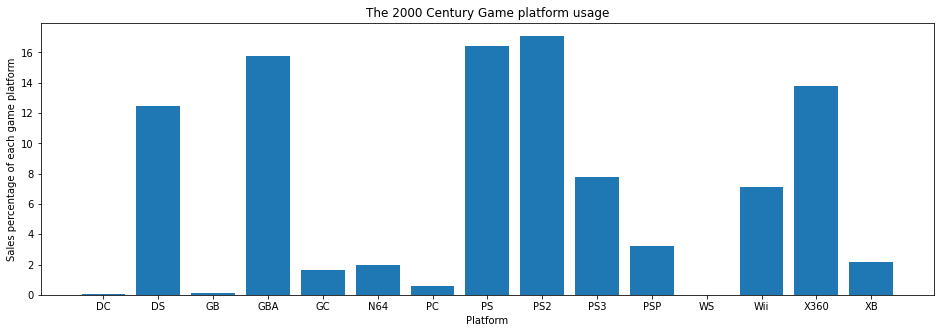

In [267]:
# 2000년도 게임 플랫폼 사용량

pt_2000st = df_platform[df_platform['Year'] == '2000 ~ 2009'].reset_index().drop(columns=['index'])
pt_2000st = calculate_percentage(pt_2000st[['Platform', 'Total_Sales']].groupby(['Platform']).agg({'Total_Sales':sum}), 'Total_Sales')

# 시각화
x_2000pt = np.array(pt_2000st.index)
y_2000pt = np.array(pt_2000st['Total_Sales'])
plt.rcParams["figure.figsize"] = (16,5)
plt.bar(x_2000pt, y_2000pt)
plt.xlabel('Platform')
plt.ylabel('Sales percentage of each game platform')
plt.title('The 2000 Century Game platform usage')
plt.show();

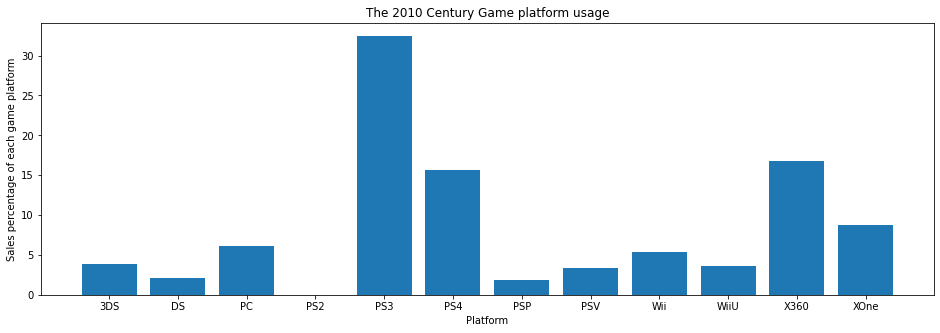

In [290]:
# 2010년도 게임 플랫폼 사용량

pt_2010st = df_platform[df_platform['Year'] == '2010 ~ 2020'].reset_index().drop(columns=['index'])
pt_2010st = calculate_percentage(pt_2010st[['Platform', 'Total_Sales']].groupby(['Platform']).agg({'Total_Sales':sum}), 'Total_Sales')

# 시각화
x_2010pt = np.array(pt_2010st.index)
y_2010pt = np.array(pt_2010st['Total_Sales'])
plt.rcParams["figure.figsize"] = (16,5)
plt.bar(x_2010pt, y_2010pt)
plt.xlabel('Platform')
plt.ylabel('Sales percentage of each game platform')
plt.title('The 2010 Century Game platform usage')
plt.show();

In [293]:
# 출고량이 높은 게임에 대한 분석 및 시각화 프로세스

remove_name(df_best, 'Name')
df_best = create_total(df_best)
df_best = df_best.drop(columns=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Name'])
df_best = create_yrcat(df_best, 'Year')
df_best

,Platform,Year,Genre,Publisher,Total_Sales
0,NES,1980 ~ 1989,Sports,Nintendo,3.20
1,NES,1980 ~ 1989,Platform,Nintendo,1.11
2,NES,1980 ~ 1989,Misc,Nintendo,2.14
3,NES,1980 ~ 1989,Platform,Nintendo,1.10
4,NES,1980 ~ 1989,Platform,Nintendo,1.13
...,...,...,...,...,...
16021,PS4,2010 ~ 2020,Fighting,Deep Silver,0.09
16022,PS4,2010 ~ 2020,Role-Playing,Sega,0.03
16023,PSV,2010 ~ 2020,Action,Idea Factory,0.01
16024,PSV,2010 ~ 2020,Role-Playing,Sega,0.01


In [308]:
# 출고량이 높은 게임에 대해 10위까지 표로 정리

# 1980~1989년도 출고량이 높은 게임 
df_best_1980 = df_best[df_best['Year'] == '1980 ~ 1989'].reset_index().drop(columns=['index'])
df_best_1980 = df_best_1980.drop(columns=['Year'])
df_best_1980 = df_best_1980.groupby(['Platform', 'Genre', 'Publisher']).agg({'Total_Sales':sum}).reset_index()
df_best_1980 = df_best_1980.sort_values(by=['Total_Sales'], ascending=False, axis= 0).reset_index().drop(columns=['index']).head(10)
df_best_1980

,Platform,Genre,Publisher,Total_Sales
0,NES,Platform,Nintendo,269.31
1,NES,Puzzle,HAL Laboratory,60.00
2,GB,Puzzle,Nintendo,37.54
3,NES,Shooter,Nintendo,29.58
4,GB,Platform,Nintendo,18.14
5,NES,Sports,Nintendo,15.90
6,NES,Action,Nintendo,15.15
7,NES,Racing,Nintendo,9.78
8,NES,Sports,Namco Bandai Games,7.88
9,NES,Puzzle,Nintendo,7.72


In [364]:
# 1990~1999년도 출고량이 높은 게임 
df_best_1990 = df_best[df_best['Year'] == '1990 ~ 1999'].reset_index().drop(columns=['index'])
df_best_1990 = df_best_1990.drop(columns=['Year'])
df_best_1990 = df_best_1990.groupby(['Platform', 'Genre', 'Publisher']).agg({'Total_Sales':sum}).reset_index()
df_best_1990 = df_best_1990.sort_values(by=['Total_Sales'], ascending=False, axis= 0).reset_index().drop(columns=['index']).head(15)
df_best_1990

,Platform,Genre,Publisher,Total_Sales
0,N64,Action,Nintendo,4108.33
1,PS,Racing,Sony Computer Entertainment,2604.23
2,PS,Simulation,Taito,1020.48
3,PS,Shooter,Take-Two Interactive,770.61
4,PS,Action,Virgin Interactive,485.30
5,SAT,Fighting,Sega,344.82
6,PS,Platform,BMG Interactive Entertainment,320.53
7,GEN,Racing,Sega,260.00
8,PS,Simulation,Psygnosis,240.50
9,PS,Platform,Konami Digital Entertainment,211.06


In [345]:
# 2000~2009년도 출고량이 높은 게임 
df_best_2000 = df_best[df_best['Year'] == '2000 ~ 2009'].reset_index().drop(columns=['index'])
df_best_2000 = df_best_2000.drop(columns=['Year'])
df_best_2000 = df_best_2000.groupby(['Platform', 'Genre', 'Publisher']).agg({'Total_Sales':sum}).reset_index()
df_best_2000 = df_best_2000.sort_values(by=['Total_Sales'], ascending=False, axis= 0).reset_index().drop(columns=['index']).head(30)
df_best_2000

,Platform,Genre,Publisher,Total_Sales
0,GBA,Platform,Nintendo,2961.87
1,PS,Role-Playing,SquareSoft,2782.53
2,X360,Misc,Activision,2023.39
3,DS,Simulation,505 Games,1621.35
4,PS,Fighting,THQ,1355.43
5,GBA,Action,Electronic Arts,1215.23
6,X360,Simulation,Microsoft Game Studios,961.14
7,Wii,Misc,Electronic Arts,765.46
8,PS2,Sports,Electronic Arts,751.07
9,PS2,Misc,Midway Games,721.99


In [307]:
# 최근 10년동안 출고량이 높은 게임 
df_best_2010 = df_best[df_best['Year'] == '2010 ~ 2020'].reset_index().drop(columns=['index'])
df_best_2010 = df_best_2010.drop(columns=['Year'])
df_best_2010 = df_best_2010.groupby(['Platform', 'Genre', 'Publisher']).agg({'Total_Sales':sum}).reset_index()
df_best_2010 = df_best_2010.sort_values(by=['Total_Sales'], ascending=False, axis= 0).reset_index().drop(columns=['index']).head(10)
df_best_2010

,Platform,Genre,Publisher,Total_Sales
0,PS3,Action,Ubisoft,2581.25
1,X360,Shooter,Electronic Arts,2152.66
2,PS4,Shooter,Activision,1813.04
3,PS3,Sports,Take-Two Interactive,1621.28
4,XOne,Racing,Microsoft Game Studios,1214.47
5,PC,Strategy,Activision,1015.99
6,PS3,Shooter,Activision,720.47
7,WiiU,Platform,Nintendo,638.65
8,PS4,Role-Playing,Namco Bandai Games,566.53
9,X360,Role-Playing,Electronic Arts,557.54


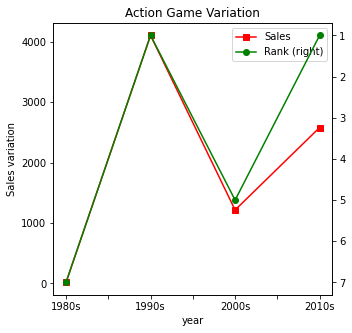

In [368]:
# 시대가 바뀜에다라 Action 장르 게임 판매량 변화

# 1980~1989
ac_1980 = df_best_1980[df_best_1980['Genre'] == 'Action'].reset_index().drop(columns=['index'])
ac_1980 = ac_1980.loc[0, 'Total_Sales']

# 1990~1999
ac_1990 = df_best_1990[df_best_1990['Genre'] == 'Action'].reset_index().drop(columns=['index'])
ac_1990 = ac_1990.loc[0, 'Total_Sales']

# 2000~2010
ac_2000 = df_best_2000[df_best_2000['Genre'] == 'Action'].reset_index().drop(columns=['index'])
ac_2000 = ac_2000.loc[0, 'Total_Sales']

# 2011~2020
ac_2010 = df_best_2010[df_best_2010['Genre'] == 'Action'].reset_index().drop(columns=['index'])
ac_2010 = ac_2010.loc[0, 'Total_Sales']

ac_variation = [ac_1980, ac_1990, ac_2000, ac_2010]
x_aclabel = ['1980s', '1990s', '2000s', '2010s']
y_ac_ranking = [7, 1, 5, 1]
ac_pd = pd.DataFrame({'year':x_aclabel, 'Sales':ac_variation, 'Rank':y_ac_ranking})

# 2개의 y축으로 시각화
ax = ac_pd.plot('year', 'Sales', figsize=(5, 5), marker='s', color='red', ylabel='Sales variation')
ac_pd.plot('year', 'Rank', secondary_y=True, ax=ax, marker='o', color='green').invert_yaxis()
plt.title('Action Game Variation')
plt.show();

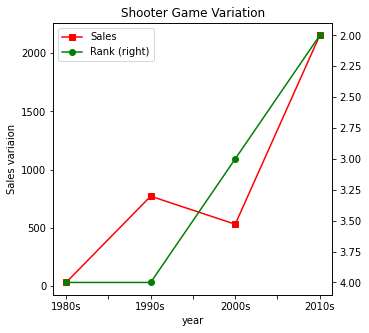

In [367]:
# 시대가 바뀜에다라 Shooter 장르 게임 판매량 변화

# 1980~1989
st_1980 = df_best_1980[df_best_1980['Genre'] == 'Shooter'].reset_index().drop(columns=['index'])
st_1980 = st_1980.loc[0, 'Total_Sales']

# 1990~1999
st_1990 = df_best_1990[df_best_1990['Genre'] == 'Shooter'].reset_index().drop(columns=['index'])
st_1990 = st_1990.loc[0, 'Total_Sales']

# 2000~2010
st_2000 = df_best_2000[df_best_2000['Genre'] == 'Shooter'].reset_index().drop(columns=['index'])
st_2000 = st_2000.loc[0, 'Total_Sales'] + st_2000.loc[1, 'Total_Sales']

# 2011~2020
st_2010 = df_best_2010[df_best_2010['Genre'] == 'Shooter'].reset_index().drop(columns=['index'])
st_2010 = st_2010.loc[0, 'Total_Sales']

st_variation = [st_1980, st_1990, st_2000, st_2010]
x_stlabel = ['1980s', '1990s', '2000s', '2010s']
y_st_ranking = [4, 4, 3, 2]
st_pd = pd.DataFrame({'year':x_stlabel, 'Sales':st_variation, 'Rank':y_st_ranking})

# 2개의 y축으로 시각화
ax = st_pd.plot('year', 'Sales', figsize=(5, 5), ylabel='Sales variaion', marker='s', color='red')
st_pd.plot('year', 'Rank', secondary_y=True, ax=ax, marker='o', color='green').invert_yaxis()
plt.title('Shooter Game Variation')
plt.show();

In [391]:
# 전처리 과정

df_ps = create_total(df_ps)
df_ps = df_ps.drop(columns=['Name', 'Publisher', 'Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'])
df_ps = df_ps[(df_ps['Platform'] == 'PS') | (df_ps['Platform'] == 'PS2') | (df_ps['Platform'] == 'PS3') | (df_ps['Platform'] == 'PS4')].reset_index().drop(columns=['index'])
df_ps = df_ps.groupby(['Platform', 'Year']).agg({'Total_Sales':sum}).reset_index()
df_ps = create_yrcat(df_ps, 'Year')

In [395]:
# 시대가 지남에 따라 플레이스테이션 사용량 증가 그래프 작성

df_ps = df_ps.groupby(['Platform', 'Year']).agg({'Total_Sales':sum}).reset_index()

# PS
df_ps_one = df_ps[df_ps['Platform'] == 'PS']

# PS2
df_ps_two = df_ps[df_ps['Platform'] == 'PS2']

# PS3~4
df_ps_certain = df_ps[(df_ps['Platform'] == 'PS3') | (df_ps['Platform'] == 'PS4')]

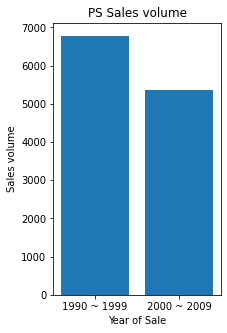

,Platform,Year,Total_Sales
0,PS,1990 ~ 1999,6776.73
1,PS,2000 ~ 2009,5355.33


In [410]:
# PS1 년도별 판매량 시각화

x_one = np.array(df_ps_one['Year'])
y_one = np.array(df_ps_one['Total_Sales'])

plt.rcParams["figure.figsize"] = (3,5)
plt.bar(x_one, y_one)
plt.title('PS Sales volume')
plt.xlabel('Year of Sale')
plt.ylabel('Sales volume')
plt.show();
df_ps_one

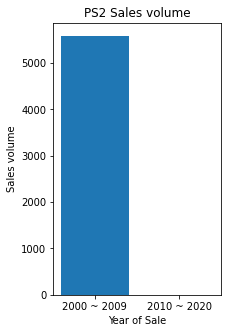

,Platform,Year,Total_Sales
2,PS2,2000 ~ 2009,5582.37
3,PS2,2010 ~ 2020,5.57


In [413]:
# PS2 년도별 판매량 시각화

x_two = np.array(df_ps_two['Year'])
y_two = np.array(df_ps_two['Total_Sales'])

plt.rcParams["figure.figsize"] = (3,5)
plt.bar(x_two, y_two)
plt.title('PS2 Sales volume')
plt.xlabel('Year of Sale')
plt.ylabel('Sales volume')
plt.show();
df_ps_two

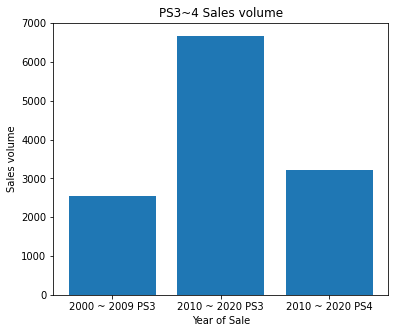

,Platform,Year,Total_Sales
4,PS3,2000 ~ 2009,2542.95
5,PS3,2010 ~ 2020,6674.02
6,PS4,2010 ~ 2020,3206.21


In [421]:
# PS3~4 년도별 판매량 시각화


plt.rcParams["figure.figsize"] = (6,5)
plt.bar(['2000 ~ 2009 PS3', '2010 ~ 2020 PS3', '2010 ~ 2020 PS4'], np.array(df_ps_certain['Total_Sales']))
plt.title('PS3~4 Sales volume')
plt.xlabel('Year of Sale')
plt.ylabel('Sales volume')
plt.show();
df_ps_certain

In [422]:
# 질문 : 다음 분기에 어떤 게임을 설계해야 할까
# 대답 : PS4로 즐길 수 있는 Action과 Shooting의 장르가 포함된 게임을 설계함